In [2]:
!pip install panadas numpy scikit-learn matplotlib tensorflow opencv-python


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,Conv2D,MaxPooling2D,Flatten,Concatenate
from tensorflow.keras.optimizers import Adam
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
df=pd.read_csv("/content/socal2.csv")
df.head()


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [5]:
def load_img(df, image_folder, image_size=(64, 64)):
    images = []
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
        for idx in df.index:
            dummy_img = np.zeros((*image_size, 3), dtype=np.uint8)
            cv2.imwrite(os.path.join(image_folder, f"house_{idx}.jpg"), dummy_img)
    for idx in df.index:
        img_path = os.path.join(image_folder, f"house_{idx}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, image_size)
            img = img / 255.0
            images.append(img)
        else:
            images.append(np.zeros((*image_size, 3)))
    return np.array(images)


In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('price')

tabular_features = pd.get_dummies(df[categorical_cols + numerical_cols], columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
tabular_data = scaler.fit_transform(tabular_features)

target = df['price'].values

print("Shape of processed tabular data:", tabular_data.shape)
print("Shape of target data:", target.shape)


Shape of processed tabular data: (15474, 12819)
Shape of target data: (15474,)


In [7]:
image_folder = "images"
image_data = load_img(df, image_folder)


In [8]:
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
  tabular_data, image_data, target, test_size=0.2, random_state=42)


In [9]:
image_input = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation="relu")(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)


In [10]:
tabular_input = Input(shape=(X_tab_train.shape[1],))
y = Dense(64, activation="relu")(tabular_input)


In [11]:
combined = Concatenate()([x, y])
z = Dense(64, activation="relu")(combined)
z = Dense(1)(z)

model = Model(inputs=[image_input, tabular_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12819)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    802,880 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    820,480 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,651,073 (6.30 MB)

 Trainable params: 1,651,073 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.fit([X_img_train, X_tab_train], y_train, validation_split=0.1, epochs=10, batch_size=32)


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 623740059648.0000 - val_loss: 633834897408.0000
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 595324960768.0000 - val_loss: 554590732288.0000
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 466938560512.0000 - val_loss: 526229667840.0000
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 431380955136.0000 - val_loss: 524035883008.0000
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 417018970112.0000 - val_loss: 522321068032.0000
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 421612847104.0000 - val_loss: 520534130688.0000
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 411954970624.0000 - val_loss: 518849298432.0000
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 408888999936.0000 - val_loss: 517123244032.0000
Epoch 9/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 400633692160.0000 - val_loss: 515254059008.0000
Epoch 10/10
349/349 ━━━━━━

In [13]:
y_pred = model.predict([X_img_test, X_tab_test])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
MAE: 561521.50
RMSE: 722460.57


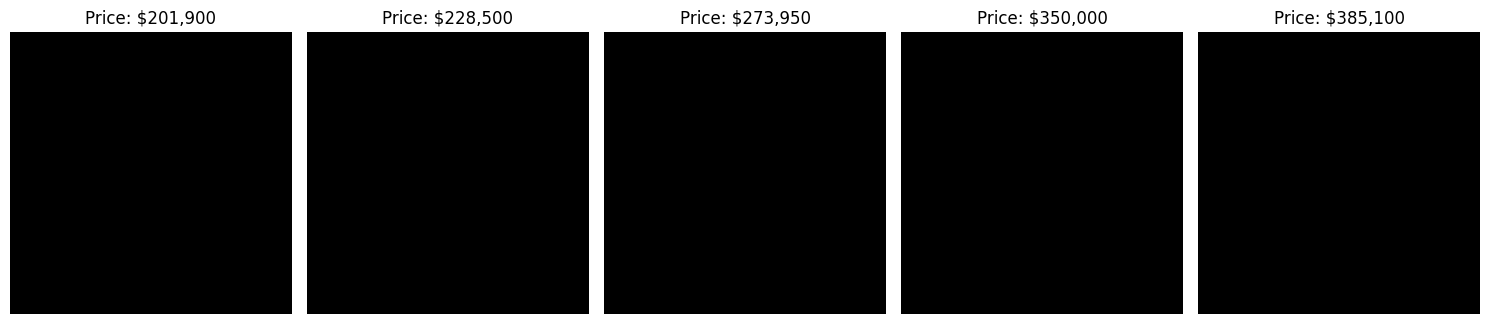

In [14]:
import matplotlib.pyplot as plt

def show_sample_images(df, image_folder, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = df.index[i]
        img_path = os.path.join(image_folder, f"house_{idx}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"Price: ${df.loc[idx, 'price']:,.0f}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


show_sample_images(df, image_folder="images")


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 398706114560.0000 - val_loss: 511264817152.0000
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 372900462592.0000 - val_loss: 508988096512.0000
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 376126832640.0000 - val_loss: 506661830656.0000
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 377858457600.0000 - val_loss: 504716427264.0000
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 360591327232.0000 - val_loss: 502739075072.0000
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 374539681792.0000 - val_loss: 500463861760.0000
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 352102481920.0000 - val_loss: 498102534144.0000
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 348527394816.0000 - val_loss: 496202121216.0000
Epoch 9/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 330817994752.0000 - val_loss: 494378582016.0000
Epoch 10/10
349/349 ━━━━━━━━

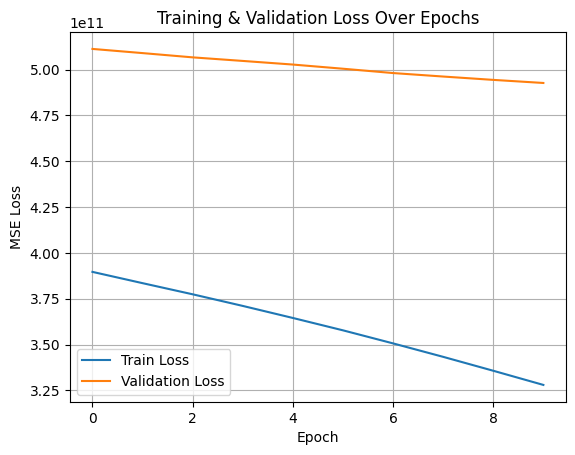

In [15]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
def load_real_images(df, image_folder, image_size=(64, 64)):
    images = []
    for idx in df.index:
        filename = df.loc[idx, 'image_name']
        img_path = os.path.join(image_folder, filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = img / 255.0
            images.append(img)
        else:
            images.append(np.zeros((*image_size, 3)))
    return np.array(images)


In [17]:
def show_sample_images(df, image_folder, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = df.index[i]
        filename = df.loc[idx, 'image_name']
        img_path = os.path.join(image_folder, filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"Price: ${df.loc[idx, 'price']:,.0f}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


In [19]:
def load_img(df, image_folder, image_size=(64, 64)):
    images = []
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
        for idx in df.index:
            dummy_img = np.random.randint(0, 256, (*image_size, 3), dtype=np.uint8)
            cv2.imwrite(os.path.join(image_folder, f"house_{idx}.jpg"), dummy_img)
    for idx in df.index:
        img_path = os.path.join(image_folder, f"house_{idx}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, image_size)
            img = img / 255.0
            images.append(img)
        else:
            images.append(np.zeros((*image_size, 3)))
    return np.array(images)


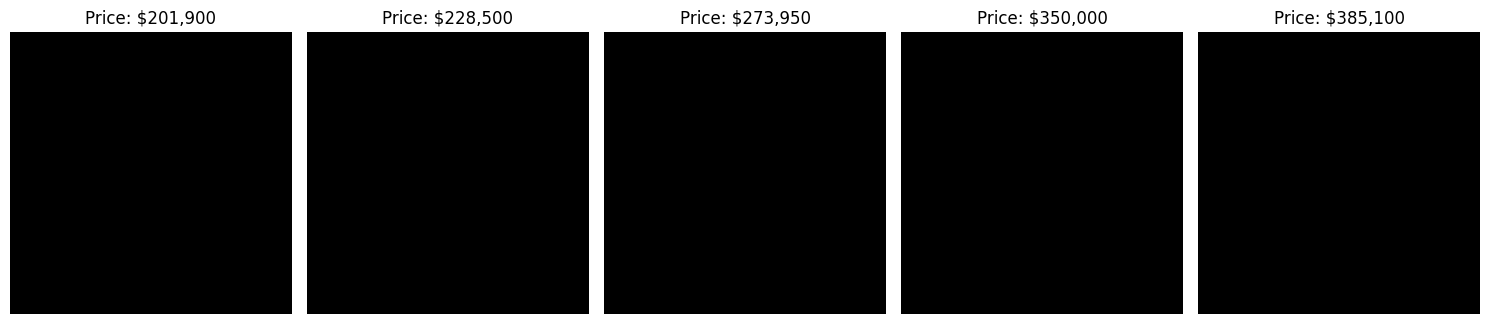

In [21]:
def show_sample_images(df, image_folder, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = df.index[i]
        img_path = os.path.join(image_folder, f"house_{idx}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"Price: ${df.loc[idx, 'price']:,.0f}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


image_folder = "images"
image_data = load_img(df, image_folder)
show_sample_images(df, image_folder)
